# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2021-11-11'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


# Initialize stim circuit

In [4]:
# AFTER_CLIFFORD_DEPOLARIZATION = 0.8e-3
# AFTER_RESET_FLIP_PROBABILITY = 0.1e-2
# BEFORE_MEASURE_FLIP_PROBABILITY = 0.5e-2 
# BEFORE_ROUND_DATA_DEPOLARIZATION = 0.8e-2

# Good error rate _resets = True
AFTER_CLIFFORD_DEPOLARIZATION = 3e-2
AFTER_RESET_FLIP_PROBABILITY = 0.8e-2
BEFORE_MEASURE_FLIP_PROBABILITY = 1e-2 
BEFORE_ROUND_DATA_DEPOLARIZATION = 3e-2

# AFTER_CLIFFORD_DEPOLARIZATION = 3e-9
# AFTER_RESET_FLIP_PROBABILITY = 0.8e-9
# BEFORE_MEASURE_FLIP_PROBABILITY = 1e-9
# BEFORE_ROUND_DATA_DEPOLARIZATION = 3e-9


SHOTS = int(1e4)

In [5]:
import stim
stim_circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=AFTER_CLIFFORD_DEPOLARIZATION, #two-qubit-fidelity,
                                after_reset_flip_probability=AFTER_RESET_FLIP_PROBABILITY, #reset error,
                                before_measure_flip_probability=BEFORE_MEASURE_FLIP_PROBABILITY, #measurement error,
                                before_round_data_depolarization=BEFORE_ROUND_DATA_DEPOLARIZATION) #idle error)



meas_outcomes = stim_circuit.compile_sampler().sample(SHOTS)
counts = {}
for row in meas_outcomes:
    count_str = ''
    for nb, bit in enumerate(row):
        count_str += '0' if bit == False else '1'
        if (nb+1) % (DISTANCE-1) == 0 and nb < ROUNDS*(DISTANCE-1):
            count_str += ' ' 
    count_str = count_str[::-1]
    if count_str in counts:
        counts[count_str] += 1
    else:
        counts[count_str] = 1
print(counts)

{'1000000 100000 100000 100000 100000 100000 100000 000000': 9, '0111100 100010 111010 111010 110010 110110 000110 000000': 1, '0110000 101000 100010 101000 101000 101100 111000 110000': 1, '0000001 010001 000001 001001 000001 000001 000001 000000': 1, '0001001 001101 001101 001101 000001 000001 000000 000001': 1, '0001011 001111 001111 001111 000111 000011 000011 000000': 1, '1111101 100011 000001 100111 101101 101101 101101 000001': 1, '0000000 000000 000000 000000 010000 000000 100000 000000': 1, '0000000 000000 000000 000000 000010 000000 000000 000000': 7, '0000011 011010 011000 011000 011000 011000 011000 011000': 1, '0001011 001110 001110 001110 001100 001100 001001 000000': 1, '0000000 100000 000000 100000 100100 100000 100000 000000': 1, '0000000 000000 010000 000000 000000 000000 000000 000000': 9, '0110000 101000 101000 110000 000000 010000 000101 000001': 1, '0000100 000110 100110 000110 000010 000110 000010 000000': 1, '0000000 000000 000000 000000 000000 100000 000000 000

In [6]:
# not correct if we look at the count string!
verbose = False

no_reset_counts = {}
for count_key, shots in counts.items():
    parts=count_key.split(" ")
    print("parts:", parts) if verbose else None
    count_part = parts[0]
    print("count_part:", count_part) if verbose else None  
    check_parts = parts[1:]
    print("check_parts:", check_parts, "\n") if verbose else None

    for i in range(len(check_parts)):
        if i == 0:
            print("skipped last check part:", check_parts[-1], "\n") if verbose else None
            continue
        current_check_str = check_parts[-(i+1)]
        print("current_check_str:", current_check_str) if verbose else None
        prev_check_str = check_parts[-i]
        print("prev_check_str:", prev_check_str) if verbose else None
        new_check_str = ''
        for bit1, bit2 in zip(prev_check_str, current_check_str):
            new_check_str += str(int(bit1)^int(bit2))
        print("new_check_str:", new_check_str, "\n") if verbose else None
        check_parts[-(i+1)] = new_check_str

    print("\ncheck_parts after modulo:", check_parts) if verbose else None

    new_count_str = count_part + " " +  ' '.join(check_parts)
    print("\nnew_count_str:", new_count_str) if verbose else None

    
    if new_count_str in no_reset_counts:
        no_reset_counts[new_count_str] += shots
    else:
        no_reset_counts[new_count_str] = shots

# if _RESETS is False:
#     print("Taking no reset counts")
#     counts = no_reset_counts
# else: 
#     print("Taking reset counts")

# print(counts)

In [55]:
import numpy as np
P_AMBIG = 0.2
np.random.seed(0)

iq_dict = simulator.generate_IQ_dict()
extreme_IQ_data_reset = simulator.counts_to_IQ_extreme(P_AMBIG, iq_dict, counts)
extreme_IQ_data_no_reset = simulator.counts_to_IQ_extreme(P_AMBIG, iq_dict, no_reset_counts)

100%|██████████| 8830/8830 [00:03<00:00, 2765.46it/s]


# Decode IQ data

In [56]:
import pymatching
import stim

model = stim_circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [57]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

_RESETS = True

result_reset = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data_reset,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True, p_offset = 1)
print("num_errors:", result_reset.num_errors, "out of", len(extreme_IQ_data_reset), "shots for _RESETS =", _RESETS, "and P_AMBIG =", P_AMBIG)

num_errors: 159 out of 10000 shots for _RESETS = True and P_AMBIG = 0.2


In [58]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

_RESETS = False

result_no_reset = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data_no_reset,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True, p_offset = 1)
print("num_errors:", result_no_reset.num_errors, "out of", len(extreme_IQ_data_no_reset), "shots for _RESETS =", _RESETS, "and P_AMBIG =", P_AMBIG)

num_errors: 258 out of 10000 shots for _RESETS = False and P_AMBIG = 0.2


# Plot the results

In [59]:
print("\nreset:", result_reset.indices, "\nno reset:", result_no_reset.indices)


reset: [109, 464, 490, 594, 653, 662, 697, 750, 847, 933, 992, 997, 1003, 1175, 1517, 1529, 1534, 1616, 1710, 1718, 1808, 1820, 1838, 1945, 2325, 2353, 2375, 2380, 2409, 2499, 2555, 2572, 2733, 2752, 2808, 2850, 2859, 2920, 2970, 3315, 3339, 3430, 3516, 3581, 3591, 3593, 3596, 3613, 3691, 3752, 3924, 4030, 4041, 4042, 4052, 4085, 4158, 4212, 4240, 4267, 4282, 4417, 4544, 4632, 4633, 4723, 4793, 4894, 4916, 4955, 4993, 5052, 5165, 5221, 5243, 5307, 5312, 5364, 5374, 5516, 5570, 5571, 5585, 5594, 5691, 5693, 5700, 5713, 5852, 5869, 5928, 5950, 6108, 6154, 6455, 6471, 6572, 6647, 6702, 6728, 6751, 6829, 6836, 6852, 6876, 6985, 7010, 7029, 7093, 7165, 7237, 7251, 7271, 7282, 7289, 7460, 7540, 7602, 7622, 7694, 7720, 7741, 7757, 7794, 7848, 7942, 7991, 8006, 8099, 8222, 8242, 8376, 8422, 8445, 8481, 8518, 8568, 8779, 8782, 8832, 8912, 9026, 9039, 9210, 9283, 9296, 9333, 9444, 9488, 9658, 9709, 9730, 9743, 9821, 9847, 9906, 9926, 9945, 9959] 
no reset: [14, 58, 123, 464, 585, 594, 653, 662,

-----resets-----


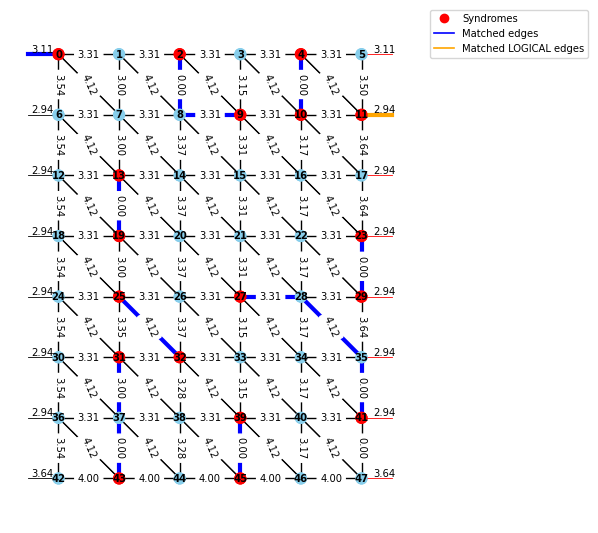

-----no resets-----


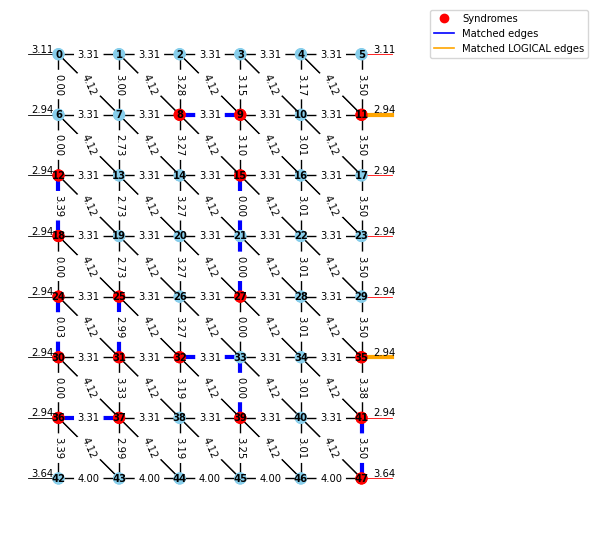

In [64]:
from soft_info import draw_matching_graph


index = 14

fig_size = (4, 13)
scale_factor = 0.6

to_be_result = result_reset
details = to_be_result.error_details[index]
print("-----resets-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_no_reset
details = to_be_result.error_details[index]
print("-----no resets-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [62]:
reset_not_in_no_reset = sorted(set(result_reset.indices) - set(result_no_reset.indices))
print("indices that are in reset but not in no_reset with len:", len(reset_not_in_no_reset))
print(reset_not_in_no_reset)
no_reset_not_in_reset = sorted(set(result_no_reset.indices) - set(result_reset.indices))
print("\nindices that are in no_reset but not in reset with len:", len(no_reset_not_in_reset))
print(no_reset_not_in_reset)
_in_both = sorted(set(result_no_reset.indices) & set(result_reset.indices))
print("\nindices that are in both with len:", len(_in_both))
print(_in_both)

indices that are in reset but not in no_reset with len: 68
[109, 490, 750, 992, 1003, 1175, 1616, 1710, 1718, 2375, 2499, 2555, 2572, 2970, 3315, 3924, 4030, 4041, 4042, 4212, 4240, 4632, 4894, 4955, 4993, 5052, 5243, 5364, 5374, 5570, 5691, 5700, 5713, 5852, 5869, 5928, 6108, 6572, 6728, 6751, 6829, 6876, 6985, 7010, 7093, 7237, 7251, 7271, 7602, 7622, 7694, 7720, 7741, 7757, 7794, 7848, 8222, 8481, 8779, 8832, 9026, 9039, 9296, 9730, 9847, 9926, 9945, 9959]

indices that are in no_reset but not in reset with len: 167
[14, 58, 123, 585, 779, 925, 1012, 1023, 1089, 1153, 1290, 1328, 1337, 1397, 1519, 1577, 1581, 1584, 1706, 1879, 1974, 2002, 2049, 2111, 2133, 2167, 2198, 2256, 2265, 2367, 2437, 2441, 2623, 2631, 2782, 2839, 2891, 2979, 3008, 3010, 3069, 3075, 3149, 3153, 3161, 3164, 3241, 3479, 3513, 3628, 3753, 3786, 3842, 3861, 3989, 4047, 4222, 4320, 4391, 4401, 4431, 4439, 4535, 4652, 4674, 4687, 4693, 4782, 4806, 4848, 4852, 4979, 4981, 5019, 5054, 5072, 5151, 5212, 5223, 5259, 53

# Analyse specific shots

In [ ]:
from tqdm import tqdm

index = 64
IQ_data = extreme_IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True)


print(cpp_soft_info.get_counts(IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print("-----IQ-----")
# draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        # matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

{'0000000 000000 100000 111111 111111 111010 000001 000000': 1}


100%|██████████| 133/133 [00:00<00:00, 1460320.50it/s]

mean time edge weight: 2.763497672024338
-----IQ-----
